In [6]:
import numpy as np
import pandas as pd
import requests
import os
import urllib.request
from bs4 import BeautifulSoup

## Telechargement des fichiers

In [40]:
r = requests.get("https://www.vendeeglobe.org/fr/classement/20210127_140000")

# str en précisant un encodage
content = r.content.decode('utf-8')
soup = BeautifulSoup(content)
for option in soup.find("select", attrs={"class": "form__input m--select onsubmit-rank"}).findAll("option")[1:]:
    lien = "https://www.vendeeglobe.org/download-race-data/vendeeglobe_" +option.attrs["value"]+".xlsx"
    urllib.request.urlretrieve(lien, "C:\\Users\\HP\\Desktop\\Projet final Kit BigData\\fichiers\\"+lien.split('/')[-1])



## Modification des fichiers excels pour permettre leur lecture par Pandas

In [46]:
# Cette fonction permet d'ouvrir chaque fichier et l'enregistrer
import win32com.client
current_dir = os. getcwd()
file_dir  = current_dir+'\\fichiers'
for filename in os.listdir(file_dir): 
    file= os.path.splitext(filename)[0]
    o = win32com.client.Dispatch("Excel.Application")
    o.Visible = False
    wb = o.Workbooks.Open(current_dir+"\\fichiers\\" + file) 
    wb.ActiveSheet.SaveAs(current_dir+"\\" + file + ".xlsx", 51) 
    o.Application.Quit()

## Chargement et concatenation des dataframes de fichiers de classement

In [47]:
import glob

def df_chargement():
    df = pd.DataFrame()
    files = glob.glob('*.xlsx')
    files.sort()
    for filename in files:
        excel = pd.read_excel(filename,header=[3,4],skiprows=range(38,45))
        excel['Date'] = filename[-20:-5]
        df = df.append(excel, ignore_index=True)
    return df

In [48]:
df=df_chargement()

In [49]:
df.head()

Unnamed: 0_level_0         Rang\nRank Nat. / Voile\nNat. / Sail  \
  Unnamed: 0_level_1 Unnamed: 1_level_1        Unnamed: 2_level_1   
0                NaN                  1                  \nFRA 18   
1                NaN                  2                  \nMON 10   
2                NaN                  3                   \nFRA 8   
3                NaN                  4                  \nFRA 59   
4                NaN                  5                  \nFRA 53   

                    Skipper / Bateau\nSkipper / crew                    \
                                  Unnamed: 3_level_1 Heure FR\nHour FR   
0                      Louis Burton\nBureau Vallée 2        15:30 FR\n   
1  Boris Herrmann\nSeaexplorer - Yacht Club De Mo...    15:31 FR\n1min   
2                              Jérémie Beyou\nCharal        15:30 FR\n   
3                           Thomas Ruyant\nLinkedOut        15:30 FR\n   
4                      Maxime Sorel\nV And B Mayenne        15:30 FR\n   

                                          Depuis 30 minutes\nSince 30 minutes  \
  Latitude\nLatitude Longitude\nLongitude                        Cap\nHeading   
0         46°24.46'N           01°50.48'W                                241°   
1         46°24.34'N           01°49.82'W                                241°   
2         46°24.91'N           01°49.99'W                                244°   
3         46°24.71'N           01°49.68'W                                244°   
4         46°24.59'N           01°49.56'W                                246°   

                            ...  \
  Vitesse\nSpeed  VMG\nVMG  ...   
0       17.7 kts  17.5 kts  ...   
1       11.1 kts  10.9 kts  ...   
2       15.5 kts  15.5 kts  ...   
3       13.2 kts  13.1 kts  ...   
4       10.9 kts  10.9 kts  ...   

  Depuis le dernier classement\nSince the the last report           \
                                           Vitesse\nSpeed VMG\nVMG   
0                                            0.0 kts       0.0 kts   
1                                            0.0 kts       0.0 kts   
2                                            0.0 kts       0.0 kts   
3                                            0.0 kts       0.0 kts   
4                                            0.0 kts       0.0 kts   

                     Depuis 24 heures\nSince 24 hours                          \
  Distance\nDistance                     Cap\nHeading Vitesse\nSpeed VMG\nVMG   
0          2788.0 nm                             201°        0.3 kts  0.3 kts   
1          2787.9 nm                             196°        0.3 kts  0.2 kts   
2          2788.5 nm                             199°        0.2 kts  0.2 kts   
3          2788.3 nm                             196°        0.2 kts  0.2 kts   
4          2788.1 nm                             195°        0.8 kts  0.7 kts   

                                     DTF                 DTL             Date  
  Distance\nDistance Unnamed: 19_level_1 Unnamed: 20_level_1                   
0             6.1 nm          24293.9 nm              0.0 nm  20201108_140000  
1             6.0 nm          24294.2 nm              0.4 nm  20201108_140000  
2             5.5 nm          24294.3 nm              0.5 nm  20201108_140000  
3             5.6 nm          24294.5 nm              0.6 nm  20201108_140000  
4             5.8 nm          24294.5 nm              0.6 nm  20201108_140000  

[5 rows x 22 columns]

## Nettoyage des donnés du dataframe du classement

In [56]:
def conversion(coord):
    directions = {'N':1, 'S':-1, 'E': 1, 'W':-1}
    result = coord.replace(u'°',' ').replace('\'',' ').replace('.',' ')
    result = result.split()
    direction = result.pop()
    result.extend([0,0,0])
    return (int(result[0])+int(result[1])/60.0+int(result[2])/3600.0) * directions[direction]

df4=df.copy()
df4= df4.droplevel(level=1, axis= 1)
#Renommer les colonnes
df4.columns = ['A_supprimer', 'Rang', 'Nat. / Voile',
       'Skipper / Bateau', 'Heure FR',
       'Latitude', 'Longitude',
       'Depuis 30 minutes:Cap',
       'Depuis 30 minutes:Vitesse',
       'Depuis 30 minutes:VMG',
       'Depuis 30 minutes:Distance',
       'Depuis le dernier classement:Cap',
       'Depuis le dernier classement:Vitesse',
       'Depuis le dernier classement:VMG',
       'Depuis le dernier classement:Distance',
       'Depuis 24 heures:Cap', 
       'Depuis 24 heures:Vitesse',
       'Depuis 24 heures:VMG', 
       'Depuis 24 heures:Distance',
       'DTF', 'DTL', 'Date']

#Nettoyage du rang
df4=df4[(df4['Rang']!='RET') & (df4['Rang']!='NL')]
df4['Rang']=df4['Rang'].astype(int)

#Nettoyage des colonnes Latitude et longitude
df4[['Latitude','Longitude']]=df4[['Latitude','Longitude']].applymap(conversion)

#Nettoyage de la colonne DLT
df4['DTL']= df4['DTL'].str.extract('(\d+,*\.*\d*)\s*\w*')[0].str.replace(',','.').astype(float)

#Nettoyage de la colonne DTF
df4['DTF']= df4['DTF'].str.extract('(\d+,*\.*\d*)\s*\w*')[0].str.replace(',','.').astype(float)

#Nettoyage de la colonne Depuis 24 heures:Distance
df4['Depuis 24 heures:Distance']= df4['Depuis 24 heures:Distance'].str.extract('(\d+,*\.*\d*)\s*\w*')[0].str.replace(',','.').astype(float)

#Nettoyage de la colonne Depuis 24 heures:VMG
df4['Depuis 24 heures:VMG']= df4['Depuis 24 heures:VMG'].str.extract('(\d+,*\.*\d*)\s*\w*')[0].str.replace(',','.').astype(float)

#Nettoyage de la colonne Depuis 24 heures:Vitesse
df4['Depuis 24 heures:Vitesse']= df4['Depuis 24 heures:Vitesse'].str.extract('(\d+,*\.*\d*)\s*\w*')[0].str.replace(',','.').astype(float)

#Nettoyage de la colonne Depuis 24 heures:Cap
df4['Depuis 24 heures:Cap']= df4['Depuis 24 heures:Cap'].str.extract('(\d+,*\.*\d*)\s*\w*')[0].str.replace(',','.').astype(int)

#Nettoyage de la colonne Depuis le dernier classement:Distance
df4['Depuis le dernier classement:Distance']= df4['Depuis le dernier classement:Distance'].str.extract('(\d+,*\.*\d*)\s*\w*')[0].str.replace(',','.').astype(float)

#Nettoyage de la colonne Depuis le dernier classement:VMG
df4['Depuis le dernier classement:VMG']= df4['Depuis le dernier classement:VMG'].str.extract('(\d+,*\.*\d*)\s*\w*')[0].str.replace(',','.').astype(float)

#Nettoyage de la colonne Depuis le dernier classement:Vitesse
df4['Depuis le dernier classement:Vitesse']= df4['Depuis le dernier classement:Vitesse'].str.extract('(\d+,*\.*\d*)\s*\w*')[0].str.replace(',','.').astype(float)

#Nettoyage de la colonne Depuis le dernier classement:Cap
df4['Depuis le dernier classement:Cap']= df4['Depuis le dernier classement:Cap'].str.extract('(\d+,*\.*\d*)\s*\w*')[0].str.replace(',','.').astype(int)

#Nettoyage de la colonne Depuis 30 minutes:VMG
df4['Depuis 30 minutes:VMG']= df4['Depuis 30 minutes:VMG'].str.extract('(\d+,*\.*\d*)\s*\w*')[0].str.replace(',','.').astype(float)

#Nettoyage de la colonne Depuis 30 minutes:Vitesse
df4['Depuis 30 minutes:Vitesse']= df4['Depuis 30 minutes:Vitesse'].str.extract('(\d+,*\.*\d*)\s*\w*')[0].str.replace(',','.').astype(float)

#Nettoyage de la colonne Depuis 30 minutes:Cap
df4['Depuis 30 minutes:Cap']= df4['Depuis 30 minutes:Cap'].str.extract('(\d+)\s*\w*')[0].str.replace(',','.').astype(int)

#Nettoyage de la colonne Depuis 30 minutes:Distance
df4['Depuis 30 minutes:Distance']= df4['Depuis 30 minutes:Distance'].str.extract('(\d+,*\.*\d*)\s*\w*')[0].str.replace(',','.').astype(float)

#Nettoyage de la colonne Heure FR
var=df4['Heure FR'].str.extract('(.*) FR\n(\d*\w*)')
var[1]=var[1].apply(lambda x: '0min' if x=='' else x)
df4['Heure FR'] = (pd.to_datetime(var[0]+':00',format='%H:%M:%S')-pd.to_timedelta(var[1]) ).dt.strftime('%H:%M:%S')

#Nettoyage de la colonne Heure FR
#Ici nous avons scinder la colone"Skipper/ Bateau en deux colones "
df4[['Skipper','Bateau']]  =df4['Skipper / Bateau'].str.extract('(.*)\n(.*)')
df4=df4.drop('Skipper / Bateau',axis=1)# Suppression de la colonne

#Nettoyage de la date 
df4['Date']=pd.to_datetime(df4['Date'], format="%Y%m%d_%H%M%S")
df4.set_index(df4['Date'], drop=True, inplace=True)
df4=df4.drop('Date',axis=1)
df4.index.rename('Date', inplace=True)

# Supprimer la colonne "A_supprimer"
df4=df4.drop('A_supprimer',axis=1)

# Nettoyage de la colonne Nat. / Voile
df4['Nat. / Voile']=df4.loc[:,'Nat. / Voile'].str.replace('\n','')
df4['Nat. / Voile'].value_counts().sort_index()
df4.loc[df4['Nat. / Voile']=='FRFRA 02','Nat. / Voile']='FRA 02'
df4.loc[df4['Nat. / Voile']=='FRFRA 69','Nat. / Voile']='FRA 69'

df4.head()

,Rang,Nat. / Voile,Heure FR,Latitude,Longitude,Depuis 30 minutes:Cap,Depuis 30 minutes:Vitesse,Depuis 30 minutes:VMG,Depuis 30 minutes:Distance,Depuis le dernier classement:Cap,...,Depuis le dernier classement:VMG,Depuis le dernier classement:Distance,Depuis 24 heures:Cap,Depuis 24 heures:Vitesse,Depuis 24 heures:VMG,Depuis 24 heures:Distance,DTF,DTL,Skipper,Bateau
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-08 14:00:00,1,FRA 18,15:30:00,46.412778,-1.846667,241,17.7,17.5,0.3,357,...,0.0,2788.0,201,0.3,0.3,6.1,24293.9,0.0,Louis Burton,Bureau Vallée 2
2020-11-08 14:00:00,2,MON 10,15:30:00,46.409444,-1.839444,241,11.1,10.9,0.4,357,...,0.0,2787.9,196,0.3,0.2,6.0,24294.2,0.4,Boris Herrmann,Seaexplorer - Yacht Club De Monaco
2020-11-08 14:00:00,3,FRA 8,15:30:00,46.425278,-1.844167,244,15.5,15.5,0.5,357,...,0.0,2788.5,199,0.2,0.2,5.5,24294.3,0.5,Jérémie Beyou,Charal
2020-11-08 14:00:00,4,FRA 59,15:30:00,46.419722,-1.835556,244,13.2,13.1,0.7,357,...,0.0,2788.3,196,0.2,0.2,5.6,24294.5,0.6,Thomas Ruyant,LinkedOut
2020-11-08 14:00:00,5,FRA 53,15:30:00,46.416389,-1.832222,246,10.9,10.9,0.2,357,...,0.0,2788.1,195,0.8,0.7,5.8,24294.5,0.6,Maxime Sorel,V And B Mayenne


In [57]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13703 entries, 2020-11-08 14:00:00 to 2021-01-27 14:00:00
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Rang                                   13703 non-null  int32  
 1   Nat. / Voile                           13703 non-null  object 
 2   Heure FR                               13703 non-null  object 
 3   Latitude                               13703 non-null  float64
 4   Longitude                              13703 non-null  float64
 5   Depuis 30 minutes:Cap                  13703 non-null  int32  
 6   Depuis 30 minutes:Vitesse              13703 non-null  float64
 7   Depuis 30 minutes:VMG                  13703 non-null  float64
 8   Depuis 30 minutes:Distance             13703 non-null  float64
 9   Depuis le dernier classement:Cap       13703 non-null  int32  
 10  Depuis le dernier classement:Vitess

## Telechargement des caracteristiques techniques

In [69]:
r = requests.get("https://www.vendeeglobe.org/fr/glossaire")
content = r.content.decode('utf-8')
soup = BeautifulSoup(content)
df2= []
for item in soup.findAll("div", attrs={"class": "sv-u-1 sv-u-s-1-2 sv-u-m-1-3 sv-u-l-1-6"}):
    voilier = {caracteristique.text.split(':')[0].strip():caracteristique.text.split(':')[1].strip() for caracteristique in item.findAll('li')}
    voilier['Image']=item.find('img').attrs['src']
    voilier['Voilier']=item.find('h3', attrs={'class':'boats-list__boat-name'}).text
    voilier['Non_Skipper']=item.find('span', attrs={'class':'boats-list__skipper-name'}).text
    df2.append(voilier)
df2=pd.DataFrame(df2)
df2.head()
    


    

,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant,Image,Voilier,Non_Skipper
0,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,01 Août 2015,"18,28 m","5,85 m","4,50 m",7 t,foils,29 m,monotype,320 m2,570 m2,/medias/05/08/50821/image-r-0-280.png,NEWREST - ART & FENÊTRES,Fabrice AMEDEO
1,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,"18,28m","5,80m","4,50m",9t,2,28m,acier forgé,280 m2,560 m2,/medias/05/06/50663/image-r-0-280.png,PURE - Best Western®,Romain ATTANASIO
2,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,01 Mars 1998,"18,28m","5,54m","4,50m",9t,2,29 m,acier,260 m2,580 m2,/medias/05/04/50477/image-r-0-280.png,TSE - 4MYPLANET,Alexia BARRIER
3,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,12 Mars 2015,"18,28 m","5,80 m","4,50 m",8 t,foils,29 m,acier mécano soudé,310 m2,550 m2,/medias/05/08/50815/image-r-0-280.png,Maître CoQ IV,Yannick BESTAVEN
4,08,NaN,VPLP,CDK Technologies,18 Août 2018,"18,28 m","5,85 m","4,50 m",8t,foils,29 m,acier,320 m2,600 m2,/medias/05/04/50486/image-r-0-280.png,CHARAL,Jérémie BEYOU


## Nettoyage des donnees des caracteristiques techniques

In [101]:
df3=df2.copy()
# Nettoyage des noms des Skippers

#Nettoyage du nom des voiliers

#Nettoyage des liens des images: Ajouter la racine http
df3['Image']='https://www.vendeeglobe.org'+ df3['Image']
df3['Image']

#Nettoyage de la colone surface de voile au portant
df3['Surface de voiles au portant']= df3["Surface de voiles au portant"].str.extract('(\d+,*\d*)\s*\w*')[0].astype(float)
#Nettoyage surface de voiles au près
df3['Surface de voiles au près']= df3["Surface de voiles au près"].str.extract('(\d+,*\d*)\s*\w*')[0].astype(float)

#Nettoyage de la colonne Voile quille

#Nettoyage de la colonne Hauteur mât
df3['Hauteur mât']= df3["Hauteur mât"].str.extract('(\d+,*\d*)\s*\w*')[0].str.replace(',','.').astype(float)

#Nettoyage de la colonne Nombre de dérive

#Nettoyage de la colonne Déplacement(poids)
df3['Déplacement (poids)']= df3["Déplacement (poids)"].str.extract('(\d+,*\d*)\s*\w*')[0].str.replace(',','.').astype(float)

#Nettoyage de la colonne Tirant d'eau
df3['Tirant d\'eau']= df3['Tirant d\'eau'].str.extract('(\d+,*\d*)\s*\w*')[0].str.replace(',','.').astype(float)

#Nettoyage de la colonne Largeur
df3['Largeur']= df3['Largeur'].str.extract('(\d+,*\d*)\s*\w*')[0].str.replace(',','.').astype(float)


#Nettoyage de la colonne Longueur
df3['Longueur']= df3['Longueur'].str.extract('(\d+,*\d*)\s*\w*')[0].str.replace(',','.').astype(float)

#Nettoyage de la colonne Date de lancement

#Nettoyage de la colonne Chantier

#Nettoyage de la colonne Architecte

#Nettoyage de la colonne Ancien nom du bateau 

#Nettoyage de la colonne Numero du voile
df3.head()





,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant,Image,Voilier,Non_Skipper
0,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,01 Août 2015,18.28,5.85,4.5,7.0,foils,29.0,monotype,320.0,570.0,https://www.vendeeglobe.org/medias/05/08/50821...,NEWREST - ART & FENÊTRES,Fabrice AMEDEO
1,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,18.28,5.80,4.5,9.0,2,28.0,acier forgé,280.0,560.0,https://www.vendeeglobe.org/medias/05/06/50663...,PURE - Best Western®,Romain ATTANASIO
2,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,01 Mars 1998,18.28,5.54,4.5,9.0,2,29.0,acier,260.0,580.0,https://www.vendeeglobe.org/medias/05/04/50477...,TSE - 4MYPLANET,Alexia BARRIER
3,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,12 Mars 2015,18.28,5.80,4.5,8.0,foils,29.0,acier mécano soudé,310.0,550.0,https://www.vendeeglobe.org/medias/05/08/50815...,Maître CoQ IV,Yannick BESTAVEN
4,08,NaN,VPLP,CDK Technologies,18 Août 2018,18.28,5.85,4.5,8.0,foils,29.0,acier,320.0,600.0,https://www.vendeeglobe.org/medias/05/04/50486...,CHARAL,Jérémie BEYOU


In [102]:
#Cette fonction perme de recuperer les caracteres Alpha numerique uniquement
import re
df3.loc[df3['Non_Skipper']=='Arnaud BOISSIÈRES','Non_Skipper']='Arnaud BOISSIERES'
df3.loc[df3['Non_Skipper']=='Sam DAVIES','Non_Skipper']='Samantha DAVIES'
df3['Non_Skipper']=df3['Non_Skipper'].apply(lambda x: re.sub('\W+',' ',x).strip())
tmp_df=df4.copy()
tmp_df=tmp_df.reset_index()
tmp_df['Nom skipper miniscule']=tmp_df['Skipper'].str.lower()
tmp_df2=df3.copy()
tmp_df2['Nom skipper miniscule']=tmp_df2['Non_Skipper'].str.lower()   
df5=tmp_df.merge(tmp_df2, left_on='Nom skipper miniscule', right_on='Nom skipper miniscule')
df5.set_index('Date',  inplace=True)
df5.head()



,Rang,Nat. / Voile,Heure FR,Latitude,Longitude,Depuis 30 minutes:Cap,Depuis 30 minutes:Vitesse,Depuis 30 minutes:VMG,Depuis 30 minutes:Distance,Depuis le dernier classement:Cap,...,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant,Image,Voilier,Non_Skipper
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-08 14:00:00,1,FRA 18,15:30:00,46.412778,-1.846667,241,17.7,17.5,0.3,357,...,4.5,7.6,foils,28.0,acier,300.0,600.0,https://www.vendeeglobe.org/medias/05/04/50485...,BUREAU VALLEE 2,Louis BURTON
2020-11-08 15:00:00,8,FRA 18,17:00:00,46.357500,-2.507222,269,20.9,18.0,10.5,263,...,4.5,7.6,foils,28.0,acier,300.0,600.0,https://www.vendeeglobe.org/medias/05/04/50485...,BUREAU VALLEE 2,Louis BURTON
2020-11-08 17:00:00,11,FRA 18,18:30:00,46.370278,-3.283889,271,20.3,16.4,10.2,271,...,4.5,7.6,foils,28.0,acier,300.0,600.0,https://www.vendeeglobe.org/medias/05/04/50485...,BUREAU VALLEE 2,Louis BURTON
2020-11-08 21:00:00,8,FRA 18,22:30:00,46.279722,-4.805278,262,12.3,10.1,6.2,265,...,4.5,7.6,foils,28.0,acier,300.0,600.0,https://www.vendeeglobe.org/medias/05/04/50485...,BUREAU VALLEE 2,Louis BURTON
2020-11-09 04:00:00,11,FRA 18,05:30:00,46.476667,-7.073333,294,13.9,0.4,6.9,276,...,4.5,7.6,foils,28.0,acier,300.0,600.0,https://www.vendeeglobe.org/medias/05/04/50485...,BUREAU VALLEE 2,Louis BURTON


In [75]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13703 entries, 2020-11-08 14:00:00 to 2021-01-27 14:00:00
Data columns (total 39 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Rang                                   13703 non-null  int32  
 1   Nat. / Voile                           13703 non-null  object 
 2   Heure FR                               13703 non-null  object 
 3   Latitude                               13703 non-null  float64
 4   Longitude                              13703 non-null  float64
 5   Depuis 30 minutes:Cap                  13703 non-null  int32  
 6   Depuis 30 minutes:Vitesse              13703 non-null  float64
 7   Depuis 30 minutes:VMG                  13703 non-null  float64
 8   Depuis 30 minutes:Distance             13703 non-null  float64
 9   Depuis le dernier classement:Cap       13703 non-null  int32  
 10  Depuis le dernier classement:Vitess

## Régression linéaire entre le rang et VMG

In [91]:
#Cas de la vitesse dépuis le dernier classement

#Construnction du dataframe qui donne le rang moyen et la vitesse moyenne par Voilier
var=df5[['Depuis le dernier classement:VMG','Rang','Nat. / Voile']].groupby(by='Nat. / Voile' , dropna=True).agg({'Depuis le dernier classement:VMG':'mean','Rang':'mean'})
var.columns= ["Vitesse","Rang"]

var.head() 

,Vitesse,Rang
Nat. / Voile,,
ESP 33,10.806432,19.993776
FIN 222,9.378838,26.390041
FRA 01,12.503942,5.599585
FRA 02,12.268465,16.350622
FRA 09,12.459959,7.545643


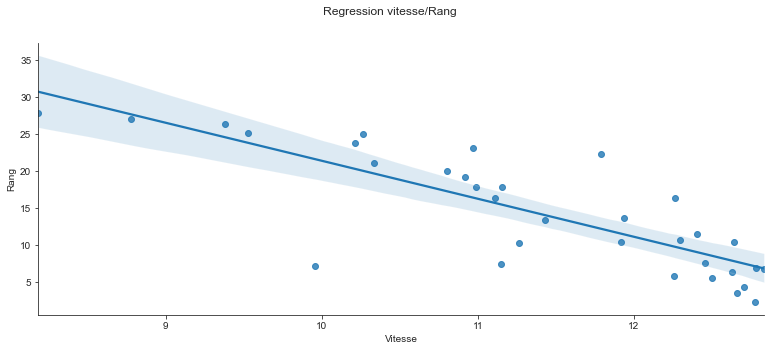

In [94]:
import seaborn as sns
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(13, 5)
fig.suptitle('Regression vitesse/Rang')
sns.regplot(x=var['Vitesse'], y=var['Rang']);
sns.despine()

## Parcourt de deux skipper sur la carte

In [88]:
from ipyleaflet import Map,Icon, Polyline, Marker
from ipyleaflet import AwesomeIcon

var1 = df5.loc[df5['Nat. / Voile'] =='FRA 72',['Latitude','Longitude']]
var2 = df5.loc[df5['Nat. / Voile'] =='ESP 33',['Latitude','Longitude']]

line1 = Polyline(
    locations=var1.values.tolist(),
    color="red" ,
    fill=False,
    weight=1,
    opacity=0.5,
    dash_array='2, 2'
)

line2 = Polyline(
    locations=var2.values.tolist(),
    color="blue" ,
    fill=False,
    weight=1,
    dashAjrray='3, 3',
    dashOffset='1'
)

depart =tuple(var1.iloc[0])

depart_marker = Marker(location=depart, draggable=True,title='Depart')

center = var1[['Latitude','Longitude']].mean()-[-20,1]
m = Map( center=tuple(center), zoom=2)
m.add_layer(line1)
m.add_layer(line2)

m.add_layer(depart_marker)
m.save('parcours.html')

m

Map(center=[-8.542802558782824, -4.559083102812353], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Capture du parcours: disponible dans le fichier html
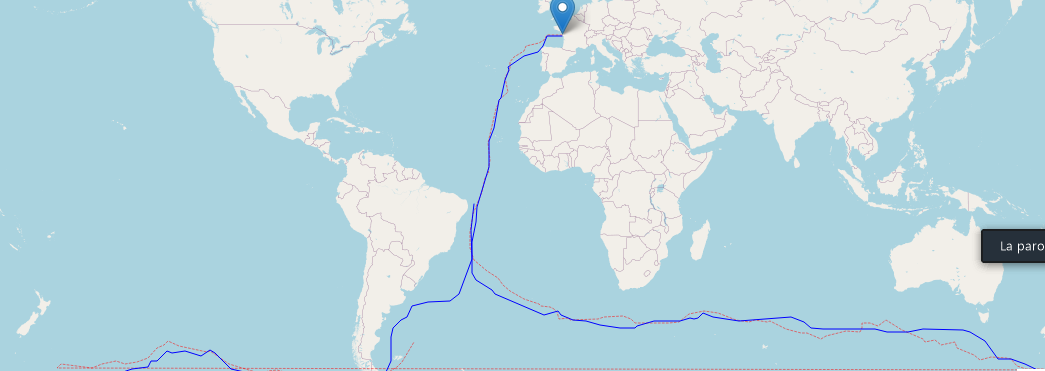

## Visualisation de la distance parcouru par voilier

,Bateau,Nat. / Voile,Depuis le dernier classement:Distance
0,APIVIA,FRA 79,30889.8
1,ARKEA PAPREC,FRA 4,11478.6
2,Banque Populaire X,FRA 30,27909.2
3,Bureau Vallée 2,FRA 18,30546.9
4,CORUM L'Épargne,FRA 6,5274.3


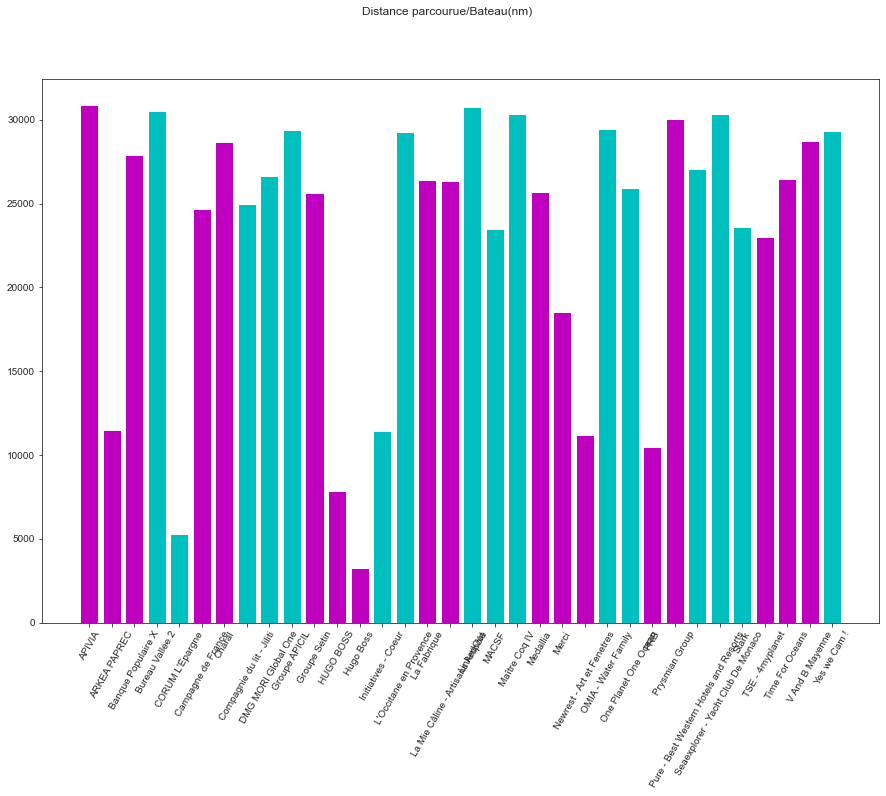

In [97]:
var=df5[['Depuis le dernier classement:Distance','Bateau','Nat. / Voile']].groupby(by=['Bateau','Nat. / Voile'] , dropna=True).agg({'Depuis le dernier classement:Distance':'sum'})
var=var.reset_index()
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Distance parcourue/Bateau(nm)')

ax = fig.subplots(1, 1, sharey=True)
fig.subplots_adjust(hspace=0.5)  # séparation verticale
ax.bar(x=var['Bateau'], height=var['Depuis le dernier classement:Distance'], color=list('mmmccmmccc')); 
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)

var.head()

## Impact du foils sur le classement et la vitesse des voiliers

,Depuis le dernier classement:VMG,Rang,Nombre de dérives
Nombre de dérives,,,
2,10.995452,17.171101,2
2 asymétriques,10.335062,21.029046,2 asymétriques
foiler,11.916456,10.398734,foiler
foils,11.931041,12.415185,foils


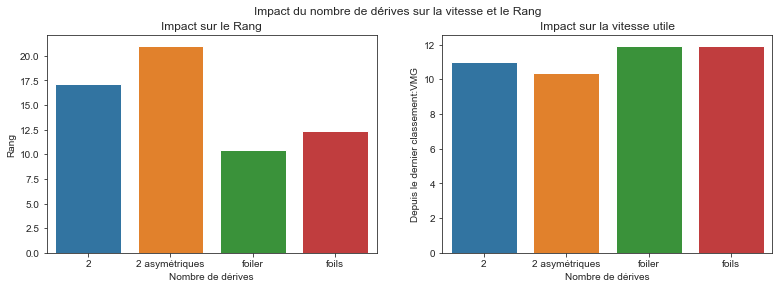

In [100]:
var=df5[['Depuis le dernier classement:VMG','Rang','Nombre de dérives']].groupby(by='Nombre de dérives' , dropna=True).agg({'Depuis le dernier classement:VMG':'mean','Rang':'mean','Nombre de dérives':'max'})

fig, axes = plt.subplots(1, 2, figsize=(13,4)) 
fig.suptitle('Impact du nombre de dérives sur la vitesse et le Rang')
axes[0].set_title('Impact sur le Rang')
axes[1].set_title('Impact sur la vitesse utile')

sns.barplot(ax=axes[0],data=var, x='Nombre de dérives', y='Rang', ci=None);
sns.barplot(ax=axes[1],data=var, x='Nombre de dérives', y='Depuis le dernier classement:VMG', ci=None);

var.head()